# Nuts and Bolts Project
**Course**: CS 4732

**Instr**: Dr. Hung

Test 2, Part 1 (Take Home)

## Description
You are asked to classify parts coming down a conveyor line as nuts, bolts or washers.
Please write your program in any programming languages to implement this pattern recognition
problem. Some images are provided for your experiments.

Example Image:
![Example Image](http://localhost:8888/view/img/bolts2.jpg "Example Nuts/Bolts Image")

Please note that this is not just *image segmentaion* problem. It is a *pattern recognition* problem. You
are encouraged to create your own images similar to the one shown below as long as your images
have nuts, bolts and washers.

Turn in:
 1. One page for your recognition system design,
 2. Your program, and
 3. Your demo.

## Design
To classify the parts in the image, we need to design a solution that can accomplish three major tasks:
 - Segment the individual objects in the image.
 - Extract a certain number of features each segmented object.
 - Classify the object based on the extracted features.
 
Here is an overview of the entire process:
![Example Image](http://localhost:8888/view/img/bolts2.jpg "Example Nuts/Bolts Image")

To implement the solution, I have chosen to use Python along with various libraries such as OpenCV, TensorFlow, Keras, etc. in order to more easily implement the designed process.

## Object Segmentation
Objective: create a process to take an input image and find all possible objects and create a create a list of all matrices that contain objects to use for feature extraction.

First, let's load an example image:

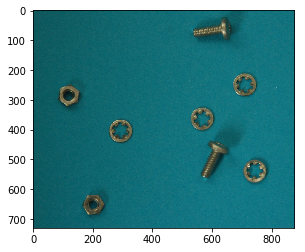

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

original = cv2.imread('./img/bolts2.jpg',1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))

A big question to answer is: what is the best way to find and extract the parts from the image? We need a way to segment the image in a way that allows us to find each individual part. Color-based segmentation using K-Means would not be a good fit for this problem. An alternative is to use morphological operators to perform texture segmentation on the object.

Reference on OpenCV Morphological Operators: [OpenCV Python Tutorial](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html)

We can use a *Morphological Gradient* to place outlines around each object in the image:

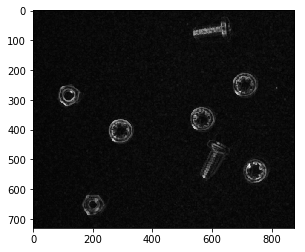

In [2]:
small_kernel = np.ones((5,5),np.uint8)

gray_image = cv2.imread('./img/bolts2.jpg',0)
gradient = cv2.morphologyEx(gray_image, cv2.MORPH_GRADIENT, small_kernel)
plt.imshow(gradient,cmap='gray')

Now, let's find the binary regions in the image that represent the objects. We can do this by applying a binary threshold and then close the image:

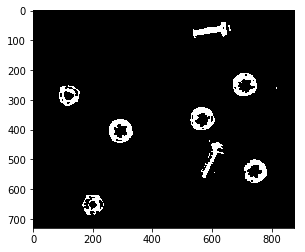

In [129]:
med_kernel = np.ones((5,5),np.uint8)

# Thresholding
ret,thresh1 = cv2.threshold(gradient,35,255,cv2.THRESH_BINARY)

# Closing Image
closing = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, med_kernel)

plt.imshow(closing,cmap='gray')